<a href="https://colab.research.google.com/github/recmit/podcast-reviews-sentiment/blob/main/bert_fine_tune.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -qq transformers watermark vaderSentiment emoji datasets evaluate ray[tune] pickle5

     |████████████████████████████████| 5.3 MB 14.0 MB/s 
     |████████████████████████████████| 125 kB 38.1 MB/s 
     |████████████████████████████████| 216 kB 69.6 MB/s 
     |████████████████████████████████| 441 kB 61.3 MB/s 
     |████████████████████████████████| 72 kB 1.3 MB/s 
     |████████████████████████████████| 59.4 MB 1.6 MB/s 
     |████████████████████████████████| 256 kB 52.6 MB/s 
     |████████████████████████████████| 7.6 MB 39.0 MB/s 
     |████████████████████████████████| 163 kB 54.0 MB/s 
     |████████████████████████████████| 115 kB 53.4 MB/s 
     |████████████████████████████████| 212 kB 52.9 MB/s 
     |████████████████████████████████| 127 kB 56.7 MB/s 
     |████████████████████████████████| 1.6 MB 46.0 MB/s 
     |████████████████████████████████| 8.8 MB 52.8 MB/s 
     |████████████████████████████████| 4.1 MB 55.3 MB/s 
     |████████████████████████████████| 125 kB 61.3 MB/s 
     |████████████████████████████████| 468 kB 70.9 MB/s 


In [ ]:
from functools import partial
import os

import pickle5 as pickle

import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, accuracy_score
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

from ray import tune
from ray.tune import JupyterNotebookReporter
from ray.tune.schedulers import ASHAScheduler

# Hugging Face
import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, get_scheduler, TrainingArguments, Trainer
import datasets
from datasets import Dataset, DatasetDict
import evaluate

from tqdm.auto import tqdm

In [ ]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device('cuda:0'  if torch.cuda.is_available() else 'cpu')

FINETUNED_SST = 'distilbert-base-uncased-finetuned-sst-2-english'
PRETRAINED = 'distilbert-base-uncased'

In [ ]:
%load_ext watermark
%watermark --iversions

ray           : 2.0.0
seaborn       : 0.11.2
torch         : 1.12.1+cu113
vaderSentiment: 3.3.2
matplotlib    : 3.2.2
sklearn       : 1.0.2
numpy         : 1.21.6
transformers  : 4.23.1
datasets      : 2.6.1
evaluate      : 0.3.0
emoji         : 2.1.0
pickle5       : 0.0.12
pandas        : 1.3.5



In [ ]:
from google.colab import drive

drive.mount('/content/drive')

PATH = 'drive/MyDrive/ml-projects/podcast-reviews/'

Mounted at /content/drive


# Training distilBERT to Predict Podcast Ratings

In a previous notebook we compared the performance of two methods to classify podcast reviews by sentiment. The VADER polarity score and a distilBERT transformer fine-tuned on the SST2 dataset, which consists of sentences from movie reviews.

In this notebook we will use the **Hugging Face** API and **PyTorch** to fine-tune the base **distilBERT** on the podcast reviews. We will train it to predict the rating given the title and body of the review. By converting the rating to sentiment, this also gives us a sentiment classifier.

Once we have trained our model, we will compare its performance with the "ready to use" model trained on SST2. Specifically we will compute accuracy and recall, and also visualize the distributions of predicted probabilities.

By base distilBERT we mean the model that has been pretrained only on two general language tasks (as opposed to sentiment analysis): predicting masked words in a sentence and predicting whether two sentences are adjacent. (Additionally the outputs of the BERT model from which it is *distilled* are used but we won't go into the details of knowledge distillation). Fine-tuning distilBERT for sentiment classification consists of adding a classification layer at the end of the transformer and then training this slightly modified transformer for sentiment classification (with a small learning rate). This is called **transfer learning**.

As part of the training process we will use **Ray Tune** to find good **hyperparameters**.

Finally, we will compare the predictions of our model with the model trained on SST2 on some reviews we will "hold out" of the training set. We picked those reviews because VADER was having a particularly hard time with them and they seemed interesting examples to test what the models have learned about podcast reviews.

**Summary of results:**
- Training distilBERT for about two epochs on 80,000 podcast reviews results in a sentiment prediction accuracy of $0.883$ on a test set of 5000 reviews. The accuracy of the distilBERT fine-tuned on SST2 on the same test set is $0.815$. The training, evaluation and test sets were constructed in such a way that all ratings are represented equally.
- Comparing the two models on some interesting reviews held out of the training set, it appears that our model learned to classify some difficult cases which are particular to the context of podcast reviews. For example, reviews of horror themed podcasts use language that would be indicative of negative sentiment in other contexts but are actually expressing approval of the show in this context.
- We measured model learning beyond the accuracy and training/evaluation loss: One observation is that the recall for positive and negative reviews gets more balanced over time, even as the accuracy and loss plateau. Another aspect we note is that the model gets more confident over time, i.e. distribution of output probabilities became more and more concentrated. This is a symptom of overfitting.

## 1. Data Cleaning
In a previous notebook we processed the reviews data but it is still a noisy dataset! We will do the following:
- Some reviews appear to be **spam**, which is why we will remove reviews by users with suspiciously high review counts.
- We will also exclude **some podcasts for kids** because a majority of the reviews for those podcasts aren't really reviews. Instead, children appear to be using the reviews as a forum in which to post jokes.
- Finally, will remove **repeat reviews** (reviews from the same user for the same podcast) to make sure there is no data leakage from the test set to the training set. I'm not sure why there are repeat reviews but I suspect that they are edited reviews. The reason we need to exclude them is that the review content is often very similar and the rating is usually the same.

**Special holdout dataset**: As mentioned, we will exclude a couple of reviews (on which we want to evaluate the models at the end) from the training set to make sure they haven't been memorized by the model (their indices are in `holdout_ids`). This is separate from the evaluation and test sets and not intended to be statistically significant, just to illustrate what the model has learned.

In [ ]:
reviews_raw = pd.read_pickle(os.path.join(PATH, 'data/reviews_raw_sentiment.pkl'))

In [ ]:
def remove_spammers(reviews, max_reviews=135):
    'Remove users with suspiciously high review count.'
    mask = reviews.groupby('user_id')['podcast_id'].transform('count') <= max_reviews
    return reviews[mask]

def keep_only_latest_rating(ratings):
    'Remove repeat reviews, keeping the latest. Also sorts the ratings by date.'
    return ratings.sort_values(by='created_at', ascending=False).drop_duplicates(subset=['podcast_id', 'user_id'])

In [ ]:
holdout_ids = = [956562, 49428, 15130, 212768, 123052, 283, 973, 1516, 2566, 14947, 922494, 9, 10, 76, 11204, 11211, 48339]
kids_podcasts = ['Wow in the World', 'Story Pirates', 'Pants on Fire', 'The Official Average Boy Podcast', 'Despicable Me', 'Rebel Girls', 'Fierce Girls', 'Like and Subscribe: A podcast about YouTube culture', 'The Casagrandes Familia Sounds', 'What If World - Stories for Kids', 'Good Night Stories for Rebel Girls', 'Gird Up! Podcast', 'Highlights Hangout', 'Be Calm on Ahway Island Bedtime Stories', 'Smash Boom Best', 'The Cramazingly Incredifun Sugarcrash Kids Podcast']

In [ ]:
reviews = (
  reviews_raw.query('name not in @kids_podcasts')
             .query('index not in @holdout_ids')
             .pipe(remove_spammers)
             .pipe(keep_only_latest_rating)
)


The classifier will expect the labels (targets) to start at 0, which is why we need to create a labels column which shifts the ratings by one.

In [ ]:
reviews['labels'] = reviews['rating'] - 1

Now we create **validation** and **test** sets, in such a way that they both have around 1000 reviews for each star rating (**uniform distribution of star ratings**). We do this to ensure that the accuracy metric treats all star ratings equally.

In [ ]:
reviews_val_test = (
    reviews.groupby('labels')
           .sample(n=2000)
)

reviews_train = reviews.query('index not in @reviews_val_test.index')
reviews_val, reviews_test = train_test_split(reviews_val_test, test_size=0.5)

In [ ]:
reviews_val['labels'].value_counts()

2    1013
4    1011
1    1007
3     989
0     980
Name: labels, dtype: int64

In [ ]:
reviews_test['labels'].value_counts()

0    1020
3    1011
1     993
4     989
2     987
Name: labels, dtype: int64

In [ ]:
reviews_train['labels'].value_counts()

4    811106
0     43229
3     26008
2     19150
1     17149
Name: labels, dtype: int64

The data has a very high skew towards 5 star ratings. We will create a **training set which contains the same amount of reviews for each rating value**, to make sure the model treats each rating class equally, so to speak. We did the same for the evaluation and test splits.

In [ ]:
reviews_train_equal = (
  reviews_train.groupby('labels')
               .sample(n=16_000)
               .sample(frac=1) #shuffle rows
)

Now we **pickle** the train, evaluation and test sets to **ensure reproducibility**. We took care to set seeds for NumPy and PyTorch at the beginning of the notebook but it is best to be careful, particularly in a notebook were cells could be run multiple times or out of order.

In [ ]:
reviews_train_equal.to_pickle(os.path.join(PATH, 'data/reviews_train_equal.pkl'))
reviews_val.to_pickle(os.path.join(PATH, 'data/reviews_val.pkl'))
reviews_test.to_pickle(os.path.join(PATH, 'data/reviews_test.pkl'))

In [ ]:
reviews_train_equal = pd.read_pickle(os.path.join(PATH, 'data/reviews_train_equal.pkl'))
reviews_val = pd.read_pickle(os.path.join(PATH, 'data/reviews_val.pkl'))
reviews_test = pd.read_pickle(os.path.join(PATH, 'data/reviews_test.pkl'))

In [ ]:
reviews_train_equal['labels'].value_counts()

4    16000
0    16000
1    16000
3    16000
2    16000
Name: labels, dtype: int64

Now we tokenize the datasets, which needs to be done before we feed them to the model. We saw in the previous notebook that under $3\%$ of reviews result in sequences of more than 256 tokens, which is why we set that as the `max_length`.

In [ ]:
train_dataset_equal = Dataset.from_dict(reviews_train_equal[['demojized review', 'labels']])
val_dataset = Dataset.from_dict(reviews_val[['demojized review', 'labels']])
# We omit 'labels' in the test_dataset because otherwise we would get an error
# when evaluating the model fine tuned on SST2 with only 2 labels, instead of 5
test_dataset = Dataset.from_dict(reviews_test[['demojized review']])
dataset_dict = DatasetDict({'train_equal':train_dataset_equal, 'validation':val_dataset, 'test':test_dataset})

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED)

In [ ]:
def tokenize_function(data, tokenizer, truncation=True, max_length=256):
    return tokenizer(data['demojized review'], truncation=truncation, max_length=max_length)

In [ ]:
tokenized_datasets = (
    dataset_dict.map(partial(tokenize_function, tokenizer=tokenizer), batched=True)
                .remove_columns(['demojized review'])
)

tokenized_datasets.set_format('torch')

## 2. Hyperparameter Search

Now we are ready to do the hyperparameter search using Hugging Face and Ray Tune. We will perform a random search over the batch sizes 8, 16 and 32, as well as learning rates between $10^{-5}$ and $10^{-4}$. This roughly agrees with the recommended parameters in the original [paper](https://arxiv.org/pdf/1810.04805.pdf) (Appendix A.3). They also recommend the epoch numbers 2, 3 and 4 but we will only use 2 epochs because that takes a long time already (and many Colab compute units 😬).

We also use an ASHA scheduler to terminate less promising trials, although in retrospect I'm not sure that is a good idea (see below). That said, with the scheduler it already took me 3 hours with a "premium GPU" on Colab and from the results it looks like the hyperparameter choice does not make a big difference (within a reasonable range).

The following function will evaluate the model during the training. It computes the accuracy and the recall. The recall is computed for every rating class and thus consists of 5 numbers.

In [ ]:
def compute_metrics(eval_preds):
  logits, labels = eval_preds
  predictions = np.argmax(logits, axis=-1)
  accuracy = accuracy_score(labels, predictions)
  recall = recall_score(
      y_true=labels,
      y_pred=predictions,
      labels=[0, 1, 2, 3, 4], 
      average=None,
  )
  metric_names = [f'recall_{n}_stars' for n in range(1, 6)] + ['accuracy']
  return dict(zip(metric_names, list(recall) + [accuracy]))

In [ ]:
training_args = TrainingArguments(
    output_dir='hugging-face-trainers',
    num_train_epochs=2,
    eval_steps=500,
    evaluation_strategy='steps',
    save_strategy='no',
    disable_tqdm=True,
)

def get_model():
  return AutoModelForSequenceClassification.from_pretrained(
      'distilbert-base-uncased',
      num_labels=5,
      ignore_mismatched_sizes=True,
)

trainer = Trainer(
    model=None,
    model_init=get_model,
    args=training_args,
    train_dataset=tokenized_datasets['train_equal'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

scheduler = ASHAScheduler(
        metric="eval_accuracy",
        mode="max",
        grace_period=4,
        reduction_factor=4,
)

def hp_space(trial):
  return {
      'learning_rate': tune.loguniform(1e-5, 1e-4),
      'per_device_train_batch_size': tune.choice([8, 16, 32]),
  }


reporter = JupyterNotebookReporter(
    parameter_columns={
        'learning_rate': 'lr',
        'per_device_train_batch_size': 'train_bs/gpu',
    },
    metric_columns=[
        'eval_accuracy', 'eval_loss', 'epoch',
        'eval_recall_1_stars', 'eval_recall_2_stars', 'eval_recall_3_stars',
        'eval_recall_4_stars', 'eval_recall_5_stars'
    ]
)

In [ ]:
best_run = trainer.hyperparameter_search(
    hp_space=hp_space,
    backend='ray',
    direction='maximize',
    n_trials=15,
    resources_per_trial={
        'cpu': 1,
        'gpu': 1/3,
    },
    scheduler=scheduler,
    checkpoint_score_attr='training_iteration',
    progress_reporter=reporter,
    local_dir=os.path.join(PATH, 'models'),
    name='hp_search_5class_uniform_ratings',
    log_to_file=True,
)

2022-10-18 13:16:03,277	INFO worker.py:1518 -- Started a local Ray instance.
/usr/local/lib/python3.7/dist-packages/ray/tune/trainable/function_trainable.py:644: DeprecationWarning: `checkpoint_dir` in `func(config, checkpoint_dir)` is being deprecated. To save and load checkpoint in trainable functions, please use the `ray.air.session` API:

from ray.air import session

def train(config):
    # ...
    session.report({"metric": metric}, checkpoint=checkpoint)

For more information please see https://docs.ray.io/en/master/ray-air/key-concepts.html#session

  DeprecationWarning,
(pid=907) The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.
0it [00:00, ?it/s]


(pid=907) Moving 0 files to the new cache system


Trial name,status,loc,lr,train_bs/gpu,lr_scheduler,eval_accuracy,eval_loss,epoch,eval_recall_1_stars,eval_recall_2_stars,eval_recall_3_stars,eval_recall_4_stars,eval_recall_5_stars
_objective_0585f_00000,TERMINATED,172.28.0.2:907,2.36886e-05,8,,0.5982,0.972204,2,0.615306,0.480636,0.499506,0.579373,0.816024
_objective_0585f_00001,TERMINATED,172.28.0.2:947,6.02131e-05,8,,0.5778,0.992277,0.8,0.646939,0.409136,0.456071,0.521739,0.855589
_objective_0585f_00002,TERMINATED,172.28.0.2:949,1.43217e-05,32,,0.5962,0.967467,2,0.639796,0.46574,0.467917,0.55814,0.849654
_objective_0585f_00003,TERMINATED,172.28.0.2:1774,2.1563e-05,32,,0.597,0.961714,2,0.633673,0.474677,0.471866,0.564206,0.840752
_objective_0585f_00004,TERMINATED,172.28.0.2:2334,9.33061e-05,16,,0.539,1.06329,0.4,0.346939,0.481629,0.563672,0.408493,0.885262
_objective_0585f_00005,TERMINATED,172.28.0.2:2670,1.51993e-05,8,,0.543,1.06707,0.2,0.517347,0.543198,0.479763,0.471183,0.701286
_objective_0585f_00006,TERMINATED,172.28.0.2:2895,4.08934e-05,8,,0.5496,1.05635,0.2,0.577551,0.474677,0.454097,0.569262,0.673591
_objective_0585f_00007,TERMINATED,172.28.0.2:3032,1.95537e-05,32,,0.597,0.962354,2,0.635714,0.473684,0.46693,0.564206,0.844708
_objective_0585f_00008,TERMINATED,172.28.0.2:3170,1.11344e-05,32,,0.5756,1.00606,0.8,0.694898,0.457795,0.378085,0.465116,0.883284
_objective_0585f_00009,TERMINATED,172.28.0.2:3273,6.09784e-05,32,,0.5948,0.974191,2,0.614286,0.46574,0.501481,0.57634,0.816024


(_objective pid=907) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.bias']
(_objective pid=907) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=907) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=907) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased

(_objective pid=907) {'loss': 1.2331, 'learning_rate': 2.309642351604977e-05, 'epoch': 0.05}
(_objective pid=947) {'loss': 1.2657, 'learning_rate': 5.87077743051891e-05, 'epoch': 0.05}
Result for _objective_0585f_00000:
  date: 2022-10-18_13-17-46
  done: false
  epoch: 0.05
  eval_accuracy: 0.5292
  eval_loss: 1.098569631576538
  eval_recall_1_stars: 0.5438775510204081
  eval_recall_2_stars: 0.48361469712015887
  eval_recall_3_stars: 0.35932872655478776
  eval_recall_4_stars: 0.4883720930232558
  eval_recall_5_stars: 0.7705242334322453
  eval_runtime: 26.4342
  eval_samples_per_second: 189.149
  eval_steps_per_second: 23.644
  experiment_id: 08c303e34a6c4444bd069c8182dd9f69
  hostname: 3e30e75aca2a
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 3.1749173011508556
  pid: 907
  time_since_restore: 95.84995007514954
  time_this_iter_s: 95.84995007514954
  time_total_s: 95.84995007514954
  timestamp: 1666099066
  timesteps_since_restore: 0
  training_iteration: 1
  trial

(_objective pid=1774) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
(_objective pid=1774) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=1774) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=1774) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-unc

Result for _objective_0585f_00002:
  date: 2022-10-18_13-40-53
  done: false
  epoch: 1.2
  eval_accuracy: 0.5838
  eval_loss: 0.9740490317344666
  eval_recall_1_stars: 0.5948979591836735
  eval_recall_2_stars: 0.5074478649453823
  eval_recall_3_stars: 0.45113524185587367
  eval_recall_4_stars: 0.5257836198179979
  eval_recall_5_stars: 0.8387734915924827
  eval_runtime: 22.3227
  eval_samples_per_second: 223.987
  eval_steps_per_second: 27.998
  experiment_id: 10db63e3a1e64d20aca7026503ceba81
  hostname: 3e30e75aca2a
  iterations_since_restore: 6
  node_ip: 172.28.0.2
  objective: 3.5018381773954106
  pid: 949
  time_since_restore: 1478.2537109851837
  time_this_iter_s: 241.33014249801636
  time_total_s: 1478.2537109851837
  timestamp: 1666100453
  timesteps_since_restore: 0
  training_iteration: 6
  trial_id: 0585f_00002
  warmup_time: 0.0035963058471679688
  
(_objective pid=949) {'eval_loss': 0.9740490317344666, 'eval_recall_1_stars': 0.5948979591836735, 'eval_recall_2_stars': 0.507

(_objective pid=2334) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight']
(_objective pid=2334) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=2334) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=2334) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-unc

(_objective pid=907) {'loss': 0.8356, 'learning_rate': 7.106591851092236e-06, 'epoch': 1.4}
Result for _objective_0585f_00000:
  date: 2022-10-18_13-59-06
  done: false
  epoch: 1.4
  eval_accuracy: 0.593
  eval_loss: 0.9777535200119019
  eval_recall_1_stars: 0.6061224489795919
  eval_recall_2_stars: 0.5561072492552135
  eval_recall_3_stars: 0.4600197433366239
  eval_recall_4_stars: 0.5005055611729019
  eval_recall_5_stars: 0.8407517309594461
  eval_runtime: 28.8259
  eval_samples_per_second: 173.455
  eval_steps_per_second: 21.682
  experiment_id: 08c303e34a6c4444bd069c8182dd9f69
  hostname: 3e30e75aca2a
  iterations_since_restore: 28
  node_ip: 172.28.0.2
  objective: 3.5565067337037775
  pid: 907
  time_since_restore: 2576.274479150772
  time_this_iter_s: 82.16083645820618
  time_total_s: 2576.274479150772
  timestamp: 1666101546
  timesteps_since_restore: 0
  training_iteration: 28
  trial_id: 0585f_00000
  warmup_time: 0.003513336181640625
  
(_objective pid=907) {'eval_loss': 0.9

(_objective pid=2670) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias']
(_objective pid=2670) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=2670) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=2670) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-unc

(_objective pid=907) {'loss': 0.8664, 'learning_rate': 2.9610799379550985e-06, 'epoch': 1.75}
(_objective pid=2670) {'loss': 1.2494, 'learning_rate': 1.4819364593777068e-05, 'epoch': 0.05}
Result for _objective_0585f_00000:
  date: 2022-10-18_14-09-51
  done: false
  epoch: 1.75
  eval_accuracy: 0.5988
  eval_loss: 0.970054030418396
  eval_recall_1_stars: 0.5897959183673469
  eval_recall_2_stars: 0.5014895729890765
  eval_recall_3_stars: 0.4906219151036525
  eval_recall_4_stars: 0.6076845298281092
  eval_recall_5_stars: 0.8041543026706232
  eval_runtime: 26.4408
  eval_samples_per_second: 189.102
  eval_steps_per_second: 23.638
  experiment_id: 08c303e34a6c4444bd069c8182dd9f69
  hostname: 3e30e75aca2a
  iterations_since_restore: 35
  node_ip: 172.28.0.2
  objective: 3.5925462389588088
  pid: 907
  time_since_restore: 3220.852831363678
  time_this_iter_s: 90.2961597442627
  time_total_s: 3220.852831363678
  timestamp: 1666102191
  timesteps_since_restore: 0
  training_iteration: 35
  tr

(_objective pid=2895) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
(_objective pid=2895) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=2895) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=2895) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-unc

Result for _objective_0585f_00003:
  date: 2022-10-18_14-14-40
  done: false
  epoch: 1.6
  eval_accuracy: 0.5938
  eval_loss: 0.9672051072120667
  eval_recall_1_stars: 0.6193877551020408
  eval_recall_2_stars: 0.4299900695134062
  eval_recall_3_stars: 0.4827245804540967
  eval_recall_4_stars: 0.5904954499494439
  eval_recall_5_stars: 0.8466864490603363
  eval_runtime: 19.3878
  eval_samples_per_second: 257.895
  eval_steps_per_second: 32.237
  experiment_id: 0c0a435c63d141db99cb3025f71f79de
  hostname: 3e30e75aca2a
  iterations_since_restore: 8
  node_ip: 172.28.0.2
  objective: 3.5630843040793243
  pid: 1774
  time_since_restore: 2046.7500295639038
  time_this_iter_s: 237.81077122688293
  time_total_s: 2046.7500295639038
  timestamp: 1666102480
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0585f_00003
  warmup_time: 0.0035245418548583984
  
(_objective pid=1774) {'eval_loss': 0.9672051072120667, 'eval_recall_1_stars': 0.6193877551020408, 'eval_recall_2_stars': 0.42

(_objective pid=3032) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias']
(_objective pid=3032) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=3032) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=3032) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-unc

Result for _objective_0585f_00006:
  date: 2022-10-18_14-17-36
  done: false
  epoch: 0.1
  eval_accuracy: 0.5264
  eval_loss: 1.114854335784912
  eval_recall_1_stars: 0.6571428571428571
  eval_recall_2_stars: 0.3445878848063555
  eval_recall_3_stars: 0.2349457058242843
  eval_recall_4_stars: 0.5267947421638018
  eval_recall_5_stars: 0.8724035608308606
  eval_runtime: 22.2503
  eval_samples_per_second: 224.716
  eval_steps_per_second: 28.09
  experiment_id: f0f75d8c3dbc441c9cd3d593d7caaa2b
  hostname: 3e30e75aca2a
  iterations_since_restore: 2
  node_ip: 172.28.0.2
  objective: 3.1622747507681597
  pid: 2895
  time_since_restore: 185.61401176452637
  time_this_iter_s: 85.17698502540588
  time_total_s: 185.61401176452637
  timestamp: 1666102656
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0585f_00006
  warmup_time: 0.003328561782836914
  
(_objective pid=2895) {'eval_loss': 1.114854335784912, 'eval_recall_1_stars': 0.6571428571428571, 'eval_recall_2_stars': 0.3445878

(_objective pid=3170) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight']
(_objective pid=3170) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=3170) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=3170) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-unc

(_objective pid=3032) {'loss': 1.1524, 'learning_rate': 1.7598337796470727e-05, 'epoch': 0.2}
Result for _objective_0585f_00007:
  date: 2022-10-18_14-21-48
  done: false
  epoch: 0.2
  eval_accuracy: 0.5582
  eval_loss: 1.0452548265457153
  eval_recall_1_stars: 0.6193877551020408
  eval_recall_2_stars: 0.5362462760675273
  eval_recall_3_stars: 0.36327739387956565
  eval_recall_4_stars: 0.40950455005055614
  eval_recall_5_stars: 0.8615232443125618
  eval_runtime: 29.9798
  eval_samples_per_second: 166.779
  eval_steps_per_second: 20.847
  experiment_id: 7a645ea2f7004f81859bbad8e9666569
  hostname: 3e30e75aca2a
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 3.3481392194122517
  pid: 3032
  time_since_restore: 265.26131534576416
  time_this_iter_s: 265.26131534576416
  time_total_s: 265.26131534576416
  timestamp: 1666102908
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0585f_00007
  warmup_time: 0.003329038619995117
  
(_objective pid=3032) {'eval_lo

(_objective pid=3273) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight']
(_objective pid=3273) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=3273) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=3273) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-unc

(_objective pid=3170) {'loss': 1.1899, 'learning_rate': 1.0020933327806927e-05, 'epoch': 0.2}
Result for _objective_0585f_00008:
  date: 2022-10-18_14-25-32
  done: false
  epoch: 0.2
  eval_accuracy: 0.5426
  eval_loss: 1.0647153854370117
  eval_recall_1_stars: 0.6173469387755102
  eval_recall_2_stars: 0.4448857994041708
  eval_recall_3_stars: 0.351431391905232
  eval_recall_4_stars: 0.4246713852376138
  eval_recall_5_stars: 0.874381800197824
  eval_runtime: 29.8364
  eval_samples_per_second: 167.581
  eval_steps_per_second: 20.948
  experiment_id: 988ed30a16c343b1a19a654720818b01
  hostname: 3e30e75aca2a
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 3.255317315520351
  pid: 3170
  time_since_restore: 277.558230638504
  time_this_iter_s: 277.558230638504
  time_total_s: 277.558230638504
  timestamp: 1666103132
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0585f_00008
  warmup_time: 0.003167867660522461
  
(_objective pid=3170) {'eval_loss': 1.0647

(_objective pid=3751) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias']
(_objective pid=3751) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=3751) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=3751) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-unc

(_objective pid=3032) {'loss': 0.9829, 'learning_rate': 9.776854331372625e-06, 'epoch': 1.0}


(_objective pid=3751) /usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
(_objective pid=3751)   FutureWarning,
(_objective pid=3751) You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Result for _objective_0585f_00007:
  date: 2022-10-18_14-40-05
  done: false
  epoch: 1.0
  eval_accuracy: 0.5878
  eval_loss: 0.9694986343383789
  eval_recall_1_stars: 0.6071428571428571
  eval_recall_2_stars: 0.5143992055610725
  eval_recall_3_stars: 0.43632773938795655
  eval_recall_4_stars: 0.5753286147623863
  eval_recall_5_stars: 0.8061325420375866
  eval_runtime: 27.5662
  eval_samples_per_second: 181.381
  eval_steps_per_second: 22.673
  experiment_id: 7a645ea2f7004f81859bbad8e9666569
  hostname: 3e30e75aca2a
  iterations_since_restore: 5
  node_ip: 172.28.0.2
  objective: 3.5271309588918593
  pid: 3032
  time_since_restore: 1362.807977437973
  time_this_iter_s: 270.5256869792938
  time_total_s: 1362.807977437973
  timestamp: 1666104005
  timesteps_since_restore: 0
  training_iteration: 5
  trial_id: 0585f_00007
  warmup_time: 0.003329038619995117
  
(_objective pid=3032) {'eval_loss': 0.9694986343383789, 'eval_recall_1_stars': 0.6071428571428571, 'eval_recall_2_stars': 0.51439

(_objective pid=3914) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
(_objective pid=3914) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=3914) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=3914) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-unc

(_objective pid=3914) {'loss': 1.2375, 'learning_rate': 3.94956683679643e-05, 'epoch': 0.05}
Result for _objective_0585f_00011:
  date: 2022-10-18_14-47-53
  done: false
  epoch: 0.05
  eval_accuracy: 0.4998
  eval_loss: 1.1463959217071533
  eval_recall_1_stars: 0.4887755102040816
  eval_recall_2_stars: 0.5263157894736842
  eval_recall_3_stars: 0.4116485686080948
  eval_recall_4_stars: 0.40546006066734075
  eval_recall_5_stars: 0.6646884272997032
  eval_runtime: 29.8732
  eval_samples_per_second: 167.374
  eval_steps_per_second: 20.922
  experiment_id: 1e1523000dc646709becfda5d9c67ce0
  hostname: 3e30e75aca2a
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 2.9966883562529043
  pid: 3914
  time_since_restore: 109.05016565322876
  time_this_iter_s: 109.05016565322876
  time_total_s: 109.05016565322876
  timestamp: 1666104473
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0585f_00011
  warmup_time: 0.023961782455444336
  
(_objective pid=3914) {'eval_los

(_objective pid=4076) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
(_objective pid=4076) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=4076) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=4076) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-unc

Result for _objective_0585f_00007:
  date: 2022-10-18_14-53-04
  done: false
  epoch: 1.6
  eval_accuracy: 0.5938
  eval_loss: 0.9682508707046509
  eval_recall_1_stars: 0.6255102040816326
  eval_recall_2_stars: 0.4260178748758689
  eval_recall_3_stars: 0.4807502467917078
  eval_recall_4_stars: 0.5884732052578362
  eval_recall_5_stars: 0.8486646884272997
  eval_runtime: 22.9839
  eval_samples_per_second: 217.544
  eval_steps_per_second: 27.193
  experiment_id: 7a645ea2f7004f81859bbad8e9666569
  hostname: 3e30e75aca2a
  iterations_since_restore: 8
  node_ip: 172.28.0.2
  objective: 3.563216219434345
  pid: 3032
  time_since_restore: 2141.9046936035156
  time_this_iter_s: 256.00309777259827
  time_total_s: 2141.9046936035156
  timestamp: 1666104784
  timesteps_since_restore: 0
  training_iteration: 8
  trial_id: 0585f_00007
  warmup_time: 0.003329038619995117
  
(_objective pid=3032) {'eval_loss': 0.9682508707046509, 'eval_recall_1_stars': 0.6255102040816326, 'eval_recall_2_stars': 0.4260

(_objective pid=4261) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias']
(_objective pid=4261) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=4261) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=4261) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-unc

(_objective pid=4261) {'loss': 1.2644, 'learning_rate': 6.271940993028646e-05, 'epoch': 0.05}
Result for _objective_0585f_00013:
  date: 2022-10-18_15-01-08
  done: false
  epoch: 0.05
  eval_accuracy: 0.497
  eval_loss: 1.1647106409072876
  eval_recall_1_stars: 0.45510204081632655
  eval_recall_2_stars: 0.5054617676266137
  eval_recall_3_stars: 0.35340572556762095
  eval_recall_4_stars: 0.48129423660262893
  eval_recall_5_stars: 0.6884272997032641
  eval_runtime: 29.7221
  eval_samples_per_second: 168.225
  eval_steps_per_second: 21.028
  experiment_id: 90415f292fea4eac98c10c4a34b0f035
  hostname: 3e30e75aca2a
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  objective: 2.980691070316454
  pid: 4261
  time_since_restore: 108.65288662910461
  time_this_iter_s: 108.65288662910461
  time_total_s: 108.65288662910461
  timestamp: 1666105268
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 0585f_00013
  warmup_time: 0.0033996105194091797
  
(_objective pid=4261) {'eval_l

(_objective pid=4370) Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
(_objective pid=4370) - This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
(_objective pid=4370) - This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
(_objective pid=4370) Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-unc

(_objective pid=4261) {'loss': 1.1729, 'learning_rate': 6.111121993207398e-05, 'epoch': 0.1}
Result for _objective_0585f_00013:
  date: 2022-10-18_15-02-35
  done: false
  epoch: 0.1
  eval_accuracy: 0.5312
  eval_loss: 1.0970174074172974
  eval_recall_1_stars: 0.5908163265306122
  eval_recall_2_stars: 0.3753723932472691
  eval_recall_3_stars: 0.40473840078973344
  eval_recall_4_stars: 0.4236602628918099
  eval_recall_5_stars: 0.8605341246290801
  eval_runtime: 29.864
  eval_samples_per_second: 167.426
  eval_steps_per_second: 20.928
  experiment_id: 90415f292fea4eac98c10c4a34b0f035
  hostname: 3e30e75aca2a
  iterations_since_restore: 2
  node_ip: 172.28.0.2
  objective: 3.186321508088505
  pid: 4261
  time_since_restore: 195.00102424621582
  time_this_iter_s: 86.3481376171112
  time_total_s: 195.00102424621582
  timestamp: 1666105355
  timesteps_since_restore: 0
  training_iteration: 2
  trial_id: 0585f_00013
  warmup_time: 0.0033996105194091797
  
(_objective pid=4261) {'eval_loss': 

2022-10-18 15:20:26,481	INFO tune.py:759 -- Total run time: 7461.08 seconds (7460.56 seconds for the tuning loop).


In [ ]:
best_run

BestRun(run_id='0585f_00000', objective=3.5890449331933936, hyperparameters={'learning_rate': 2.368863950364079e-05, 'per_device_train_batch_size': 8})

It seems that with higher batch size the accuracy is often better but at the cost of having higher recall for 1 and 5 stars and worse recall for the intermediate ratings. However, this might be an artifact of the ASHA early stopping, which appears to favor the larger batch sizes. This is probably because they converge more quickly at first given that the model gets to "see" more examples at each step. What makes me think this is indeed the case is: 1) all the completed trials except one have batch size 32 2) the only smaller batch trial that wasn't stopped early ended up having the highest accuracy (it was also the first trial and thus not subject to being stopped early).

In any case, the differences in accuracy are very small and it's not worth it to repeat the costly hyperparameter search.

## 3. Fine-Tuning distilBERT

We will use the best parameters we found above: batch size 8 and learning rate $2.44\cdot10^{-5}$. Note that because we will train with 4 epochs instead of the 2 epochs we used in the hyperparameter search, the learning rate will actually be s little higher for longer at the beginning, given that we are using a linear learning rate scheduler (the default).

In [ ]:
base_model = AutoModelForSequenceClassification.from_pretrained(
      PRETRAINED,
      num_labels=5,
      ignore_mismatched_sizes=True,
)

In [ ]:
training_args = TrainingArguments(
    output_dir=os.path.join(PATH, 'models/best-run'),
    learning_rate=2.4e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    num_train_epochs=4,
    evaluation_strategy='steps',
)

trainer = Trainer(
    model=base_model,
    args=training_args,
    train_dataset=tokenized_datasets['train_equal'],
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

using `logging_steps` to initialize `eval_steps` to 500
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 80000
  Num Epochs = 4
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 40000


Step,Training Loss,Validation Loss,Recall 1 Stars,Recall 2 Stars,Recall 3 Stars,Recall 4 Stars,Recall 5 Stars,Accuracy
500,1.245400,1.128538,0.621429,0.371400,0.318855,0.506572,0.841741,0.531600
1000,1.093900,1.104158,0.355102,0.348560,0.655479,0.425683,0.782394,0.515000
1500,1.078600,1.058309,0.416327,0.629593,0.319842,0.556117,0.807122,0.546400
2000,1.059700,1.082167,0.811224,0.345581,0.339585,0.427705,0.801187,0.544000
2500,1.051500,1.042632,0.665306,0.434955,0.320829,0.562184,0.812067,0.558400
3000,1.033800,1.027814,0.750000,0.400199,0.388944,0.485339,0.791296,0.562400
3500,1.048100,1.018655,0.706122,0.328699,0.543929,0.564206,0.717112,0.571400
4000,1.009200,1.007908,0.629592,0.470705,0.384995,0.577351,0.802176,0.572600
4500,1.027100,1.057035,0.359184,0.422046,0.571570,0.593529,0.796241,0.549600
5000,0.993200,1.007861,0.609184,0.384310,0.527147,0.549039,0.818002,0.577600


***** Running Evaluation *****
  Num examples = 5000
  Batch size = 32
Saving model checkpoint to drive/MyDrive/ml-projects/podcast-reviews/models/best-run/checkpoint-500
Configuration saved in drive/MyDrive/ml-projects/podcast-reviews/models/best-run/checkpoint-500/config.json
Model weights saved in drive/MyDrive/ml-projects/podcast-reviews/models/best-run/checkpoint-500/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/ml-projects/podcast-reviews/models/best-run/checkpoint-500/tokenizer_config.json
Special tokens file saved in drive/MyDrive/ml-projects/podcast-reviews/models/best-run/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 5000
  Batch size = 32
Saving model checkpoint to drive/MyDrive/ml-projects/podcast-reviews/models/best-run/checkpoint-1000
Configuration saved in drive/MyDrive/ml-projects/podcast-reviews/models/best-run/checkpoint-1000/config.json
Model weights saved in drive/MyDrive/ml-projects/podcast-reviews/models/be

TrainOutput(global_step=40000, training_loss=0.7883354850769043, metrics={'train_runtime': 8551.9991, 'train_samples_per_second': 37.418, 'train_steps_per_second': 4.677, 'total_flos': 1.430763981562344e+16, 'train_loss': 0.7883354850769043, 'epoch': 4.0})

For all the models we trained so far the **recall is higher for the extreme ratings** (1 and 5 stars) than for the intermediate ratings. It is especially high for 5 star ratings. Could we make the model better by having a higher proportion of "harder" ratings in the training set? We will test that idea now by creating a **new training set with unequal star rating proportions**.

In [ ]:
train_proportions = {
     0: 16000,
     1: 17000,
     2: 19000,
     3: 17000,
     4: 10000,
 }

# In case we loaded val and test with Pickle
reviews_train = (
    reviews.query('index not in @reviews_val.index')
           .query('index not in @reviews_test.index')
)

reviews_train_unequal = (
  reviews_train[['demojized review', 'labels']]
               .groupby('labels', group_keys=False)
               .apply(lambda x: x.sample(n=train_proportions[x.name]))
               .sample(frac=1)
)

train_dataset_unequal = Dataset.from_dict(reviews_train_unequal)

tokenized_train_dataset_unequal = (
    train_dataset_unequal.map(partial(tokenize_function, tokenizer=tokenizer), batched=True)
                   .remove_columns(['demojized review'])
)

In [ ]:
base_model = AutoModelForSequenceClassification.from_pretrained(
      PRETRAINED,
      num_labels=5,
      ignore_mismatched_sizes=True,
)

In [ ]:
training_args = TrainingArguments(
    output_dir=os.path.join(PATH, 'models/best-run-unequal-ratings'),
    learning_rate=2.4e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    num_train_epochs=2,
    evaluation_strategy='steps',
)

trainer = Trainer(
    model=base_model,
    args=training_args,
    train_dataset=tokenized_train_dataset_unequal,
    eval_dataset=tokenized_datasets['validation'],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 79000
  Num Epochs = 2
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 19750
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Recall 1 Stars,Recall 2 Stars,Recall 3 Stars,Recall 4 Stars,Recall 5 Stars,Accuracy
500,1.253800,1.130906,0.546939,0.423039,0.576505,0.311426,0.693373,0.511000
1000,1.160400,1.073716,0.424490,0.494538,0.401777,0.491405,0.847676,0.532800
1500,1.120700,1.062113,0.583673,0.397219,0.514314,0.493428,0.757666,0.549400
2000,1.100400,1.043622,0.667347,0.312810,0.442251,0.562184,0.798220,0.556000
2500,1.082100,1.078694,0.767347,0.211519,0.526160,0.633974,0.559842,0.538200
3000,1.076700,1.028931,0.598980,0.474677,0.503455,0.470172,0.779426,0.565600
3500,1.058500,1.041818,0.668367,0.347567,0.590326,0.518706,0.655786,0.555800
4000,1.080900,1.041594,0.748980,0.280040,0.507404,0.584429,0.684471,0.560000
4500,1.060900,1.022272,0.539796,0.618669,0.403751,0.600607,0.681503,0.568800
5000,1.030700,1.036904,0.490816,0.391261,0.593287,0.611729,0.707221,0.559200


***** Running Evaluation *****
  Num examples = 5000
  Batch size = 32
Saving model checkpoint to drive/MyDrive/ml-projects/podcast-reviews/models/best-run-unequal-ratings/checkpoint-500
Configuration saved in drive/MyDrive/ml-projects/podcast-reviews/models/best-run-unequal-ratings/checkpoint-500/config.json
Model weights saved in drive/MyDrive/ml-projects/podcast-reviews/models/best-run-unequal-ratings/checkpoint-500/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/ml-projects/podcast-reviews/models/best-run-unequal-ratings/checkpoint-500/tokenizer_config.json
Special tokens file saved in drive/MyDrive/ml-projects/podcast-reviews/models/best-run-unequal-ratings/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 5000
  Batch size = 32
Saving model checkpoint to drive/MyDrive/ml-projects/podcast-reviews/models/best-run-unequal-ratings/checkpoint-1000
Configuration saved in drive/MyDrive/ml-projects/podcast-reviews/models/best-run-unequa

TrainOutput(global_step=19750, training_loss=0.9750066875988924, metrics={'train_runtime': 5661.6116, 'train_samples_per_second': 27.907, 'train_steps_per_second': 3.488, 'total_flos': 7133320516097280.0, 'train_loss': 0.9750066875988924, 'epoch': 2.0})

Changing the rating proportions in the training set definitely improved the recall score for 3 and 4 star ratings but at the cost of the recall for 1 and 5 star ratings. The accuracy stayed the same. Depending on the use case and what our objective function or cost function is, one might want to use such a training set with hand tuned proportions of star ratings. We will not pursue this further.

## 4. Evaluating on the Test Set

Now we will compare various checkpoints of the models we fine-tuned with the distilBERT which was fine-tuned on the SST2 dataset.

We will write a function which computes the **accuracy** and **recall**, and also **plots the distributions of the probabilities** the model assigns to each class, conditional on the actual ground truth class. We will do this both for the classification into star ratings (5 classes) and for the classification into sentiment (2 classes). The latter will allow us to compare our models to the SST2 distilBERT, which is a binary classifier.

We will use the **test set** for the evaluation. For that purpose we will create `test_dataloader` and the `get_probs` function, which takes the model and the dataloader and returns the predicted probabilities.

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

test_dataloader = DataLoader(
    tokenized_datasets['test'], batch_size=32, collate_fn=data_collator
)

In [ ]:
def get_probs(model, dataloader):
  probs = []
  model = model.to(device)
  model.eval()
  m = nn.Softmax(dim=1)
  for batch in tqdm(dataloader):
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
      outputs = model(**batch)
      logits = outputs.logits
      probs += m(logits).tolist()
  return np.array(probs)

We define the **sentiment** as:
- **negative** or 0 if the rating is 3 or lower
- **positive** or 1 if the rating is 4 or 5.

The reason we make 3 negative is that the distilBERT fine-tuned on SST2 classifies most 3 star ratings as negative. Looking at the reviews they do seem mostly negative.

In [ ]:
reviews_test['sentiment'] = (reviews_test['rating'] > 3).astype(int)

The following function computes the **accuracy** and **recall** (for each class). If the sentiment argument is set to True, the classes are the binary sentiment. If a model predicts ratings, they will be converted to sentiments inside the function. If the model predictions are binary, the sentiment argument passed is ignored and set to True.

The function also **plots** histograms of **probabilities** assigned by the model in a grid. The *rows* in the grid correspond to the true classes (rating or sentiment for the review) and the *columns* correspond to the probability predictions. Each histogram consists of the probabilities that the model assigns to the class for that column when restricting to the reviews with true class given by the row. If the model is performing well, we expect the probabilities on the diagonal of the grid to concentrate at 1 and for the remaining histograms to concentrate at 0.

In [ ]:
def plot_rating_hists(probs, targets_df):
  fig, axs = plt.subplots(5, 5, figsize=(16, 8), constrained_layout=True)
  fig.suptitle(
    'Distribution of the predicted probabilities conditional on the true rating',
    size='x-large',
  )
  for y_true, ax_row in enumerate(axs):
    for y_pred, ax in enumerate(ax_row):
      sns.histplot(
          probs[targets_df['labels'] == y_true, y_pred],
          ax=ax,
          kde=True,
          bins=20,
      )
      if y_true == 0:
        ax.set_title(
            f'Probability that rating is {y_pred + 1}'
        )
      if y_pred == 0:
        ax.set_ylabel(f'True rating is {y_true + 1}', size='large')


def plot_sentiment_hists(probs, targets_df):
  fig, axs = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
  fig.suptitle(
    'Distribution of the probabilities that reviews are positive',
    size='x-large',
  )
  for sentiment in [0, 1]:
    sns.histplot(
        probs[targets_df['sentiment'] == sentiment],
        ax=axs[sentiment],
        kde=True,
        bins=20,
    )
    axs[sentiment].set_title(
            f"True sentiment is {['negative', 'positive'][sentiment]}"
    )


def evaluate_and_plot(checkpoint, dataloader, targets_df, sentiment=False):
  """targets_df must contain columns 'sentiment' (binary) and 'labels'"""
  model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
  probs = get_probs(model, dataloader)

  n_classes = probs.shape[1]
  assert n_classes in {2, 5}, 'Model must predict either rating or binary sentiment'

  if not sentiment and n_classes == 2:
    sentiment = True
    print(
      'Setting sentiment to True because the model is a binary classifier'
    )

  preds = np.argmax(probs, axis=1)
  if sentiment and n_classes == 5:
    preds = preds > 2
    probs = probs[:, 3:].sum(axis=1)
  
  if n_classes == 2:
    probs = probs[:, 1]

  if sentiment:
    plot_sentiment_hists(probs, targets_df)
  else:
    plot_rating_hists(probs, targets_df)
  
  target_col = 'sentiment' if sentiment else 'labels'
  
  return{
        'accuracy': accuracy_score(targets_df[target_col], preds),
        'recall': recall_score(targets_df[target_col], preds, average=None),
    }

Now we will use this function to evaluate what looks like it might be the best checkpoint during training, at 17,000 steps. This is a little under 2 epochs. After 17,000 steps, it appears the model is starting to overfit because at that point the evaluation slowly increases again while the training loss keeps going down. At the start of the fourth epoch we are clearly overfitting: the evaluation loss increases dramatically and the training loss just keeps going down.

  0%|          | 0/157 [00:00<?, ?it/s]

{'accuracy': 0.5886,
 'recall': array([0.66078431, 0.44008056, 0.46909828, 0.52818991, 0.84428716])}

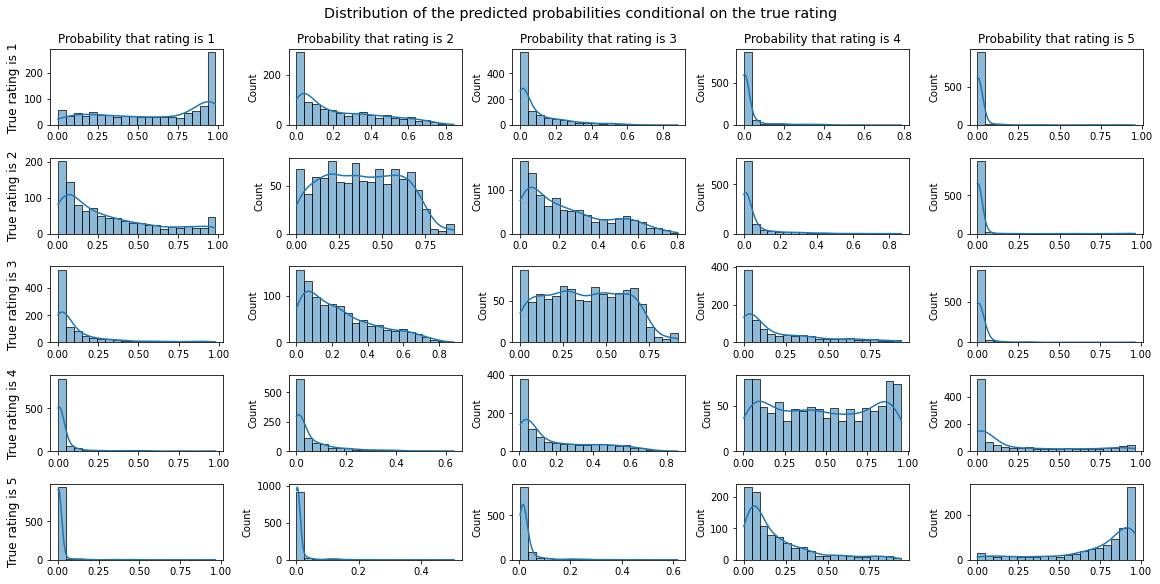

In [ ]:
evaluate_and_plot(
    os.path.join(PATH, 'models/best-run/checkpoint-17000'),
    test_dataloader,
    reviews_test,
)

We see both in the recall and in the histograms that the model has a particularly hard time with 2 and 3 star ratings.

For example, for 3 star reviews, the model is more likely than not ($53\%$ of the time) to predict a different rating (mostly 2 or 4, but sometimes 1) than to predict the correct 3 star rating. Beyond that, even if it identifies the 3 star reviews correctly almost half of the time, it is very rarely "confident" in its prediction. To be fair, when it gets 3 star reviews wrong it's almost always predicting them to be 2 star reviews and sometimes 4 star reviews.

For 5 star ratings the model does pretty well, only occasionally mistaking them for 4 star reviews. Similarly for 1 star reviews.

The histograms for 4 star reviews are interesting: The probabilities in histogram (4,4) have twin peaks at 0 and 1. When it misclassifies 4 star reviews, it is mostly as 3 and 5 stars. But the probabilities it assigns to those mistaken predictions are different. For 5 star misclassifications there is a small peak of very confident predictions, whereas the 3 star misclassifications are less confident (mostly under 0.7). See the histograms at (4,3) and at (4,5).

To compare our model to the one fine-tuned on SST2 we need to evaluate the prediction of **sentiment** (rather than ratings). We do this in the next cell and get an accuracy of $0.883$. We also get a recall of $0.895$ for negative ratings and $0.864$ for positive ratings.

This prediction accuracy is similar to those in the literature for BERT models on similar datasets. For example, the authors of the distilBERT fine-tuned on SST2 which we are using [Report](https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english) a $0.913$ accuracy. See also Table 6 in the original BERT [paper](https://arxiv.org/pdf/1810.04805.pdf).

Our model has an accuracy which is 2 or 3 percent lower than the ones I referenced, but our dataset is also significantly noisier. Taking that into account $0.883$ is a good result.

  0%|          | 0/157 [00:00<?, ?it/s]

{'accuracy': 0.8828, 'recall': array([0.89533333, 0.864     ])}

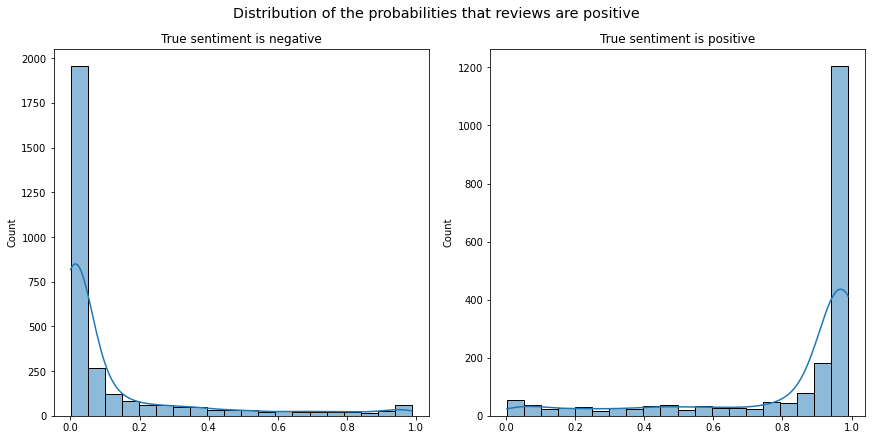

In [ ]:
evaluate_and_plot(
    os.path.join(PATH, 'models/best-run/checkpoint-17000'),
    test_dataloader,
    reviews_test,
    sentiment=True,
)

Now we evaluate the model which was fine-tuned on SST2 and is available on Hugging Face.

  0%|          | 0/157 [00:00<?, ?it/s]

{'accuracy': 0.8148, 'recall': array([0.81466667, 0.815     ])}

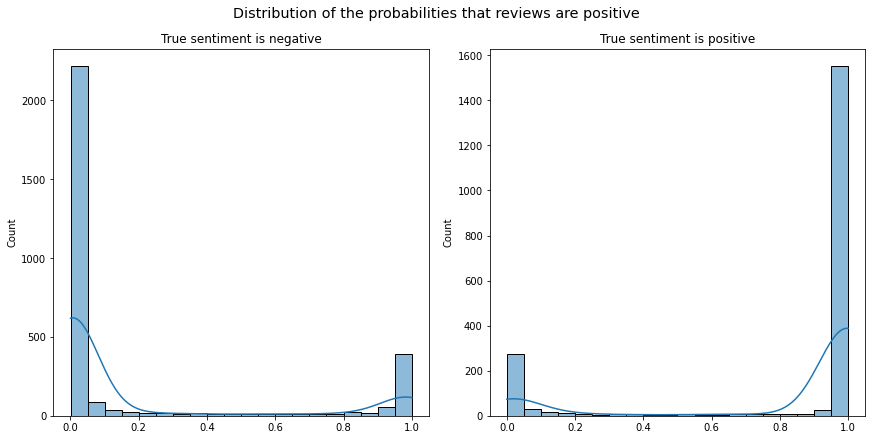

In [ ]:
evaluate_and_plot(
    FINETUNED_SST,
    test_dataloader,
    reviews_test,
    sentiment=True,
)

The model fine-tuned on SST has a lower accuracy $0.815$ and also lower recall scores of $0.815$ and $0.815$. It is remarkable how similar the recall scores of positive and negative ratings are for the distilBERT model fine-tuned on SST. After rounding they are actually identical.

The model we fine-tuned does have significantly higher accuracy and recall than the one fine-tuned on the SST2 dataset. However, this is to be expected because of two main reasons: Firstly, podcast and movie reviews have pretty different distributions and so it is not unexpected that a model trained on one would do worse on the other. But an additional factor is that the sentiment labeling for SST2 was done on *individual sentences* by *human judges*, whereas our labels are for *entire reviews* consisting of multiple sentences (which might have different sentiments even within the same review) and the labels are the *ratings*, which are certainly a noisier signal of sentiment than labels given by multiple people for the specific purpose of training a classifier.

All things considered, it is actually impressive how well the distilBERT fine-tuned on SST2 does on this data!


## 5. Evaluating the Models on some Interesting Reviews

Let's see how our model does compared to the SST2 distilBERT on the special examples we held out of the training set. We found those examples in a previous notebook by looking at misclassifications coming from VADER, and saved them because they are interesting and some of them seem to encapsulate peculiarities of podcast reviews. The idea is that a model trained directly on podcast reviews might do better on those.

In [ ]:
holdout_reviews = reviews_raw.query('index in @holdout_ids')
holdout_dataset = Dataset.from_dict(holdout_reviews[['demojized review']])
tokenized_holdout = (
    holdout_dataset.map(partial(tokenize_function, tokenizer=tokenizer), batched=True)
                   .remove_columns(['demojized review'])
)
holdout_dataloader = DataLoader(
    tokenized_holdout, batch_size=16, collate_fn=data_collator
)

In [ ]:
mymodel = AutoModelForSequenceClassification.from_pretrained(
                      os.path.join(PATH, 'models/best-run/checkpoint-17000')
)
myprobs = get_probs(mymodel, holdout_dataloader)

holdout_reviews[[f'{k} star prob' for k in range(1, 6)]] = myprobs
holdout_reviews['star pred'] = myprobs.argmax(axis=1)

pos_prob = myprobs[:, 3:].sum(axis=1)
holdout_reviews['positive prob mymodel'] = pos_prob
holdout_reviews['sentiment pred mymodel'] = (pos_prob > 0.5).astype(int)

sstmodel = AutoModelForSequenceClassification.from_pretrained(FINETUNED_SST)
sstprobs = get_probs(sstmodel, holdout_dataloader)
holdout_reviews['positive prob sstmodel'] = sstprobs[:, 1]
holdout_reviews['sentiment pred sstmodel'] = (sstprobs[:, 1] > 0.5).astype(int)

In [ ]:
holdout_reviews['sentiment'] = (holdout_reviews['rating'] > 3).astype(int)

In [ ]:
pd.crosstab(holdout_reviews['sentiment pred mymodel'], holdout_reviews['sentiment'])

sentiment,0,1
sentiment pred mymodel,,
0,11,1
1,1,4


In [ ]:
pd.crosstab(holdout_reviews['sentiment pred sstmodel'], holdout_reviews['sentiment'])

sentiment,0,1
sentiment pred sstmodel,,
0,7,4
1,5,1


Clearly the results are way better for our model than the model fine-tuned on SST2. The latter does much worse on these held out reviews than for the generic reviews. I swear I didn't cherry pick them to make our model look good! But I did pick some of them because they seemed like interesting examples that are particular to the context of podcast reviews.

Let's go over some of the reviews to see why they are interesting examples.

First there are two reviews for two different **horror themed podcasts**. I wondered if the distilBERT model would learn to classify them as positive even though they use what would be considered negative language in other context, and it appears to have worked!

In [ ]:
holdout_reviews.loc[[11204, 11211], ['review', 'rating', 'positive prob mymodel', 'positive prob sstmodel', 'polarity score']]

,review,rating,positive prob mymodel,positive prob sstmodel,polarity score
11204,The real stuff.... Genuinely disturbing horror...,5,0.948132,0.424419,-0.9390
11211,Best scare ever!. It sounds strange but I alwa...,5,0.984157,0.065295,-0.9027


In [ ]:
holdout_reviews.loc[11204, 'review']

'The real stuff.... Genuinely disturbing horror!\nThese are "take out one of the earbuds" scary, the narration kills any disconnect you may have started with, SN makes you THERE!\nMOAR!'

In [ ]:
holdout_reviews.loc[11211, 'review']

"Best scare ever!. It sounds strange but I always listen to horror stories through my headphones to help me fall asleep at night. But Knifepoint stories have literally kept me up all night hiding under the covers. I can't get enough of these terrifying stories!!"

On the next review both models agree but it **really illustrates one of the issues with VADER**. While the two distilBERT models are confident the review is negative, VADER gives it a high positive score because it contains the word "like" many times:

In [ ]:
holdout_reviews.loc[956562, 'review']

'Like like like like like like like like like. I love the concept of this podcast - but just listening to 15 minutes I really couldn’t stand how many times all of the participants said LIKE. Literally unlistenable unless you want to hear a podcast that is 50% LIKE and 50% actual content.'

In [ ]:
holdout_reviews.loc[956562, ['rating', 'positive prob mymodel', 'positive prob sstmodel', 'polarity score']]

rating                           1
positive prob mymodel     0.001567
positive prob sstmodel    0.008399
polarity score              0.9702
Name: 956562, dtype: object

Next there are two reviews discussing **sound issues**. Because this is a common complaint with podcasts, one might hypothesize that our model has learned that discussing the sound is usually associated with a negative rating. The results were mixed. The second review is arguably the harder case and our model gets it right (and the other model is extremely confident in its incorrect prediction). However, for some reason our model predicts that the first review is positive, albeit not with high confidence. Maybe "sound" is usually used in these critical reviews rather than "volume". We can't draw conclusions from just two reviews, of course.

In [ ]:
holdout_reviews.loc[[9, 123052], ['rating', 'positive prob mymodel', 'positive prob sstmodel', 'polarity score']]

,rating,positive prob mymodel,positive prob sstmodel,polarity score
9,1,0.655020,0.004309,0.4749
123052,1,0.209684,0.933054,0.9515


In [ ]:
holdout_reviews.loc[9, 'review']

'Volume???. Great podcast, but the editors turn the volume down for the talks. The intros are loud, then you have to crank up the volume for the talk.'

In [ ]:
holdout_reviews.loc[123052, 'review']

"Want to love it. I love Colbert. And I really wanted to love this podcast. But I don't always listen to podcasts in a library where it's super quiet. The sound needs to be fixed so I can hear it while I'm going about my daily life. If they fix the sound I will definitely download it again."

Then there is a review complaining about something to do with **politics**. This is a very common theme in 1 star ratings. As we might have expected, our model is much more confident of the review being negative than the one fine-tuned on SST2. The latter model usually assigns probabilities very close to 0 or 1, so 0.2 is pretty low confidence for that model.

VADER gets it completely wrong, presumably because of the word "best" and despite the word "too".

In [ ]:
holdout_reviews.loc[2566, ['rating', 'positive prob mymodel', 'positive prob sstmodel', 'polarity score']]

rating                           1
positive prob mymodel     0.004463
positive prob sstmodel     0.20247
polarity score              0.6369
Name: 2566, dtype: object

In [ ]:
holdout_reviews.loc[2566, 'review']

'Too Political. Talk about food. That’s what you do best.'

The following review contains mostly positive language (talking about how great the podcast used to be) but the word "unsubscribe". Sure enough, our model was very confident that it is a negative review whereas the SST2 distilBERT and VADER predicted positive.

In [ ]:
holdout_reviews.loc[14947, ['review', 'rating', 'positive prob mymodel', 'positive prob sstmodel', 'polarity score']]

review                    Unsubscribe. Was a huge supporter of the pod a...
rating                                                                    1
positive prob mymodel                                              0.001306
positive prob sstmodel                                             0.506458
polarity score                                                       0.6937
Name: 14947, dtype: object

Finally, **the following positive review seems like a really hard one to classify** and it's impressive that our fine-tuned distilBERT got it right! By contrast, the SST2 distilBERT and VADER were very confident that it is negative. See for yourself:

In [ ]:
holdout_reviews.loc[48339, ['rating', 'positive prob mymodel', 'positive prob sstmodel', 'polarity score']]

rating                           5
positive prob mymodel     0.932284
positive prob sstmodel    0.005084
polarity score              -0.944
Name: 48339, dtype: object

In [ ]:
holdout_reviews.loc[48339, 'review']

"This episode...all about failure.... Wow! I’m in tears! My first podcast review but it had to be done because this podcast spoke to me! \n\n I’ve spent a lot of time lately feeling bad about things I’ve missed because I  didn't lose this weight sooner, didn’t devote more time to my business sooner, didn’t figure out a way to get my irritability in check so my kids don’t have a mom that yells - could’ve, would've should’ve...these thoughts rotate through my head daily and make me feel terrible about myself and my life. But you know what bows the time. I’m not going to sit with regrets any longer!"

Here is the whole holdout dataframe. I mostly went over the reviews in which the distilBERT models disagree but you can see that they also agree in many cases. They are both generally superior to VADER.

In [ ]:
holdout_reviews[['review', 'rating', 'positive prob mymodel', 'positive prob sstmodel', 'polarity score']].head(17) # Making sure all 17 rows are shown

,review,rating,positive prob mymodel,positive prob sstmodel,polarity score
9,"Volume???. Great podcast, but the editors turn...",1,0.655020,0.004309,0.4749
10,America’s Forgotten Working Class. This episod...,5,0.939482,0.995457,-0.7269
76,One-dur-ful. **Warning**\nIf you listen to the...,5,0.108636,0.335130,-0.1779
283,Rebroadcasts after rebroadcasts. This used to ...,1,0.008035,0.625919,0.7447
973,Everything else is better. I listen to a few c...,1,0.007977,0.003618,0.7311
1516,How does it work?. Worked great on my old Ipod...,1,0.060916,0.001340,0.6249
2566,Too Political. Talk about food. That’s what yo...,1,0.004463,0.202470,0.6369
11204,The real stuff.... Genuinely disturbing horror...,5,0.948132,0.424419,-0.9390
11211,Best scare ever!. It sounds strange but I alwa...,5,0.984157,0.065295,-0.9027
14947,Unsubscribe. Was a huge supporter of the pod a...,1,0.001306,0.506458,0.6937


## 6. On Model Confidence
Something that jumps out when looking at the distributions of predicted probabilities is that the distilBERT fine-tuned on SST2 is *more confident* of its predictions than our model. The former mostly assigns probabilities close to 0 and 1 whereas the latter outputs more probabilities in between.

Over time our model also gets more confident but never reaches that level of sharpness, which might be due to our data being more noisy. Below we see the results for a relatively early model, at 6000 steps (0.6 epochs), and the last model at 40,000 steps (4 epochs).

The 6000 steps model is actually not that different to the 17,000 steps model we saw above in terms of the accuracy. However, the recall for negative reviews is significantly higher than for positive reviews, mostly because it classifies many 4 star reviews as 3 star reviews. Another difference is that the histograms are much less concentrated (less "confident") at 6000 steps.

The 40,000 steps model is clearly overfitting as at that point the evaluation loss has been going up and the training loss went down dramatically. **One of the symptoms of this overfitting is the high confidence.** The accuracy is actually worse than it was at 17,000 steps, but the histograms are much more concentrated at 0 and 1.


  0%|          | 0/157 [00:00<?, ?it/s]

{'accuracy': 0.5662,
 'recall': array([0.60588235, 0.50151057, 0.51874367, 0.36597428, 0.84226491])}

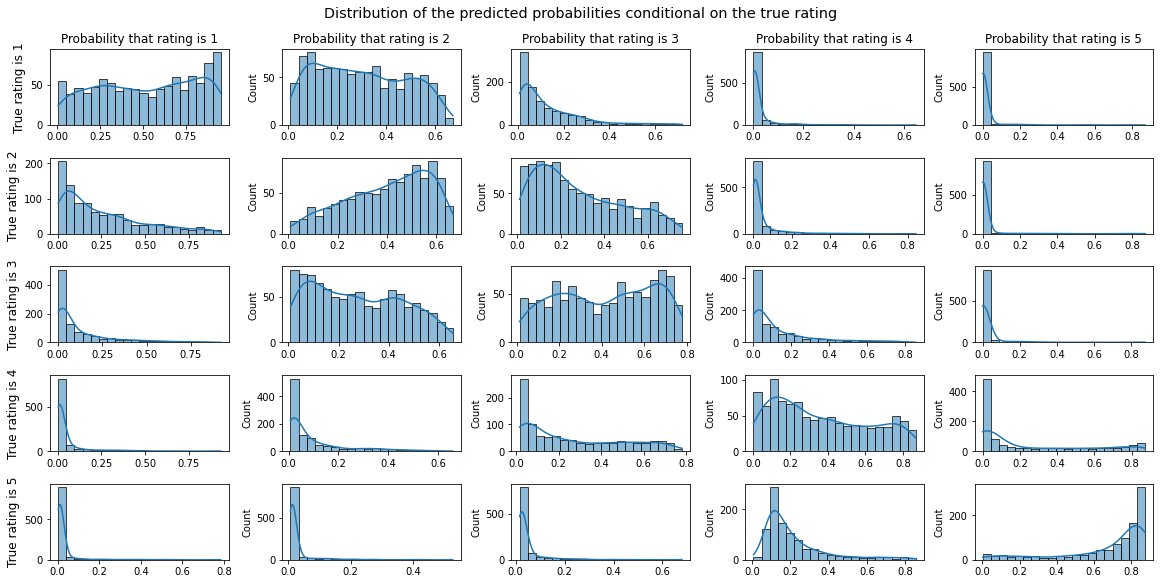

In [ ]:
evaluate_and_plot(
    os.path.join(PATH, 'models/best-run/checkpoint-6000'),
    test_dataloader,
    reviews_test,
)

  0%|          | 0/157 [00:00<?, ?it/s]

{'accuracy': 0.5708,
 'recall': array([0.59117647, 0.48539778, 0.44883485, 0.53610287, 0.79271992])}

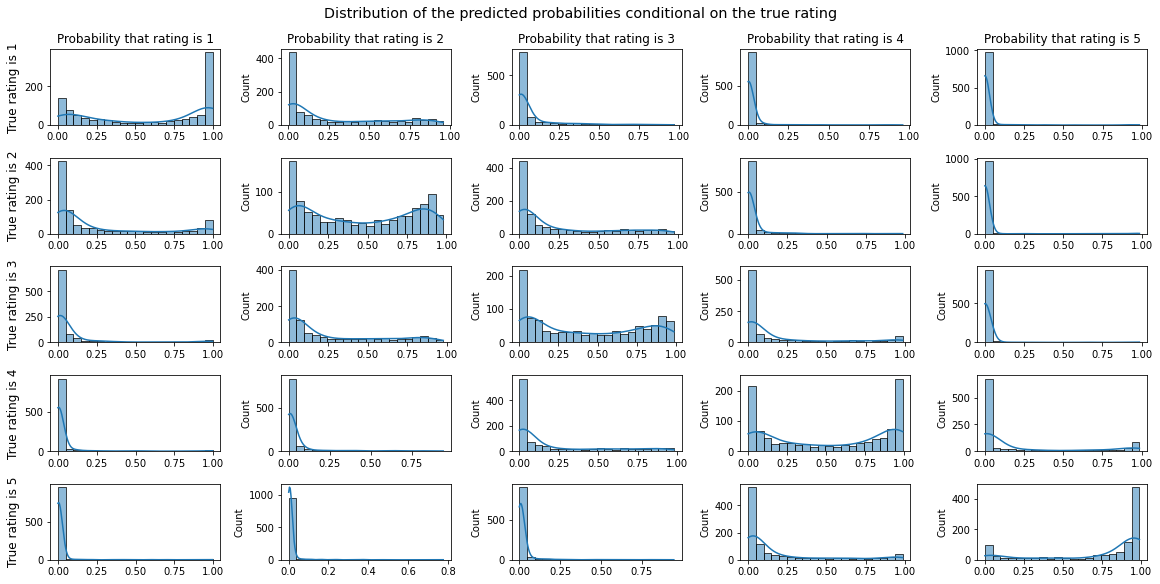

In [ ]:
evaluate_and_plot(
    os.path.join(PATH, 'models/best-run/checkpoint-40000'),
    test_dataloader,
    reviews_test,
)

  0%|          | 0/157 [00:00<?, ?it/s]

{'accuracy': 0.8744, 'recall': array([0.93233333, 0.7875    ])}

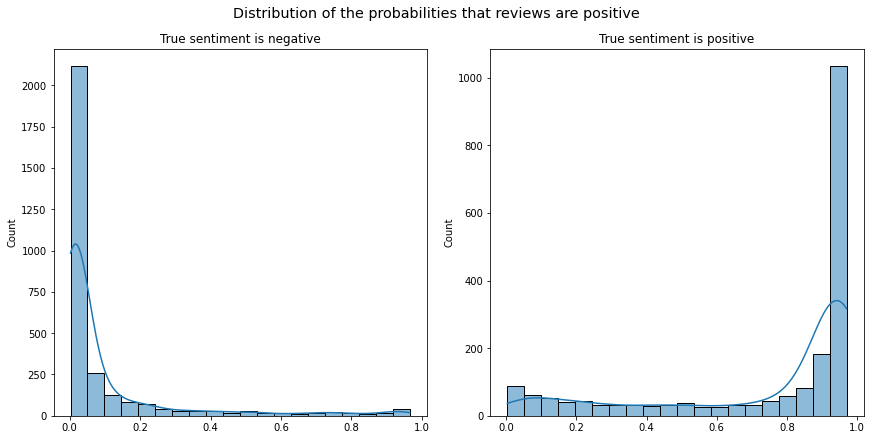

In [ ]:
evaluate_and_plot(
    os.path.join(PATH, 'models/best-run/checkpoint-6000'),
    test_dataloader,
    reviews_test,
    sentiment=True,
)

  0%|          | 0/157 [00:00<?, ?it/s]

{'accuracy': 0.8762, 'recall': array([0.895, 0.848])}

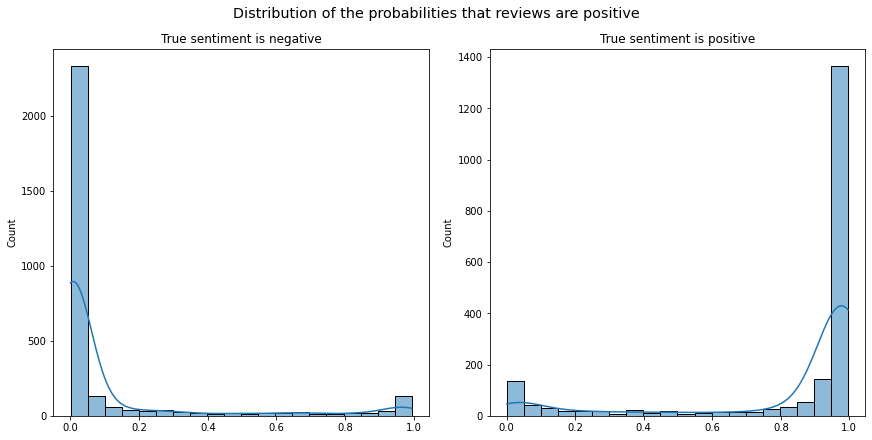

In [ ]:
evaluate_and_plot(
    os.path.join(PATH, 'models/best-run/checkpoint-40000'),
    test_dataloader,
    reviews_test,
    sentiment=True,
)